In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

RANDOM_SEED = 28022001

S(t) - Geometric Brownian Motion <br>
r > 0, $\sigma$ > 0, S(0) = 1

---
# Task1

Смоделировать процесс S(t). Проверить экспериментально формулу для математического ожидания MS(T). Увидеть зависимость скорости сходимости к математическому ожиданию от $\sigma$ (т.е. зафиксировать число случайных траекторий N, увеличивать $\sigma$ и следить за отклонением среднего от MS(T)).

$dS(t) = S(t)rdt+S(t)\sigma dW(t)$ <br>
$S(t)=S(0)e^{(r-\frac{\sigma^2}{2})t+\sigma W(t)}$
$r,\sigma\in R$, $\sigma > 0$ - волатильность, $r>0$ - безрисковая процентная ставка.

In [3]:
R = 0.1
Sigma = 0.01

In [57]:
def modulate_asset_price(S0=1, r=0.0, sigma = 0, steps=100, trajectory_num=100,
                         start=0, end=1, seed=None) -> np.ndarray:
    """
    Моделирование цены актива по формуле: 

    math: `$S(t) = S(0)e^{(r-\frac{\sigma^2}{2})t+\sigmaW(t)}$`
    
    Arguments:
        S0, float - начальная стоиомсть актива, по умолчанию 1
        r, float - безрисковая процентная ставка, по умолчанию 0.0
        sigma, float - волатильность, по умолчанию 0.0
        steps, int - количество шагов процесса, по умолчанию 100
        trajectory_num, int - количество случайных траеторий процесса, которые необходимо смоделировать
        start, float - начальное значение времени
        end, float - конечное значение времени
    
    Returns:
        S_t, np.ndarray - матрица траекторий цен актива
    """
    wiener_process_matrix = wiener_process_v2(steps=steps, trajectory_num=trajectory_num, seed=seed)
    _time = np.linspace(start, end, num=steps+1)
    degree = np.expand_dims((r - sigma ** 2 / 2)*_time, axis=0) + sigma * wiener_process_matrix
    S_t = S0 * np.exp(degree)
    return S_t


def wiener_process(initial_value=0, steps=100, trajectory_num=100):
    """
    Генерация последовательности значений, соответствующих винеровскому процессу.
    
    Arguments:
        initial_value, float - начальное значение процесса, по умолчанию 0
        steps, int - количество шагов процесса, по умолчанию 100
        trajectory_num, int - количество случайных траеторий процесса, которые необходимо смоделировать
    
    Returns:
        trajectories, np.ndarray - матрица траеторий
    """
    # создаем
    values = np.zeros((trajectory_num, steps+1))
    values[:, 0] = initial_value
    for i in range(steps):
        previous_value = values[:, i]
        np.random.seed(RANDOM_SEED)
        noise = np.random.normal(0, np.sqrt(1/steps), size=(previous_value.shape))
        new_value = previous_value + noise
        values[:,i+1] += new_value
    return values

def wiener_process_v2(initial_value=0, steps=100, trajectory_num=100, seed = None):
    values = np.zeros((trajectory_num, steps+1)) + initial_value
    if seed is not None:
        np.random.seed(seed)
    values[:, 1:] = np.random.normal(0, np.sqrt(1/steps), size=(trajectory_num, steps)) #.shape
    return np.cumsum(values, axis=1)

In [5]:
np.cumsum(np.random.normal(0, 1, size=(10, 11)), axis=1).shape

(10, 11)

<Axes: >

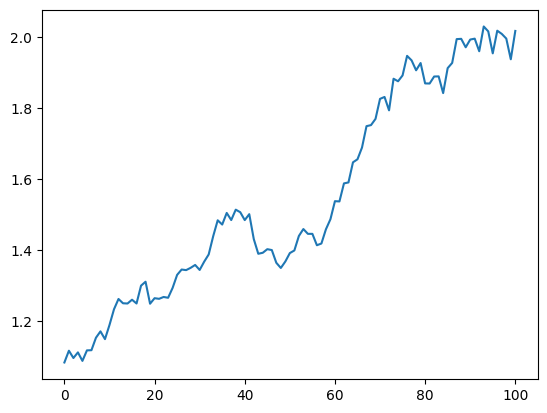

In [70]:
# sns.lineplot(modulate_asset_price(r=0.1, sigma=0.1)[0,:], legend=False)
sns.lineplot(modulate_asset_price(S0=1, r=0.1, sigma=0.2, start=1, end=8, seed=42)[65], legend=False)

$MS(T) = S(0)e^{rT}$

In [7]:
def expectationS(S0=1., r=0.0, steps=100, start=0, end=1) -> np.ndarray:
    """
    Computes theoretical expectation of S(t) in time
    math: `MS(T)=S(0)e^{rT}`

    Arguments:
        S0, float - начальная цена актива
        r, float - безрисковая процентная ставка
        steps, int - количество шагов по времени
        start, float - начальное значение времени
        end, float - конечное значение времени
        
    
    Returns:
        expectation, np.ndarray - вектор математических ожиданий
                                  цен актива по времени
    """
    _time = np.linspace(start, end, num=steps+1)
    expectationS = S0 * np.exp(r*_time)
    return expectationS

In [8]:
def calculate_empirical_expectation(S0=1, r=0.0, sigma = 0, steps=100, trajectory_num=100, S_values=None):
    if S_values is None:
        S_values = modulate_asset_price(S0=S0, r=r, sigma=sigma, steps=steps, trajectory_num=trajectory_num)
    return S_values.mean(axis=0)

In [9]:
calculate_empirical_expectation(r=R, sigma=Sigma).shape

(101,)

In [10]:
STEPS = 10
N = 10**6
R = 0.1
Sigma=0.03
S0 = 1

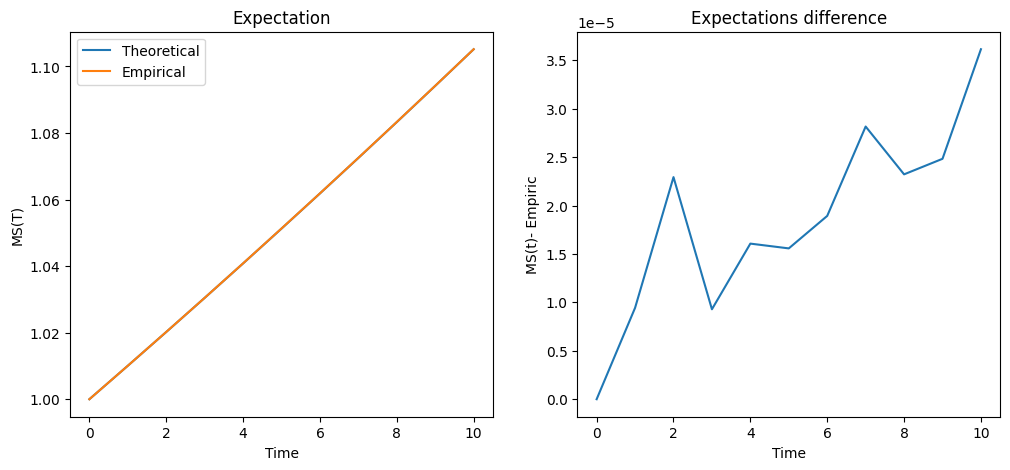

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].plot(expectationS(S0=S0, r=R, steps=STEPS), label='Theoretical')
axs[0].plot(modulate_asset_price(S0=S0, r=R, sigma=Sigma, steps=STEPS, 
                                 trajectory_num=N).mean(axis=0), label='Empirical')
axs[0].set_title('Expectation')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('MS(T)')

axs[1].plot(np.abs(expectationS(S0=S0, r=R,
                                steps=STEPS) - modulate_asset_price(S0=S0, r=R, sigma=Sigma, 
                                                                                steps=STEPS, 
                                                                                trajectory_num=N).mean(axis=0))) #/expectationS(S0=S0,r=R, steps=STEPS))
axs[1].set_title('Expectations difference')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('MS(t)- Empiric')

axs[0].legend()
plt.show()

In [12]:
def calc_empirical_expectetions_varying_sigma(sigmas: np.ndarray, S0=1, r=0.0, steps=100, 
                                              trajectory_num=100, S=None) -> np.ndarray:
    """
        Calculates an empirical expectations for different sigmas

        Arguments:
            sigmas, np.ndarray - an array of sigmas to calculate expectations
            S0, float - an asset start price
            r, float - a riskless rate value
            steps, int - a number of timesteps
            trajectory_num, int - a number of trajectories to modulate

        Returns: 
            expectations, np.ndarray - an array of expectations for a corresponding sigmas
    """

    expectations = np.zeros_like(sigmas)
    for idx, sigma in enumerate(sigmas):
        expectations[idx] += modulate_asset_price(S0=S0, r=r, sigma=sigma, steps=steps, 
                                                  trajectory_num=trajectory_num).mean(axis=0)[-1] # [-1, :].mean()
    return expectations

In [13]:
modulate_asset_price(S0=S0, r=R, sigma=Sigma, steps=10, 
                                                  trajectory_num=N)[:, -1].shape

(1000000,)

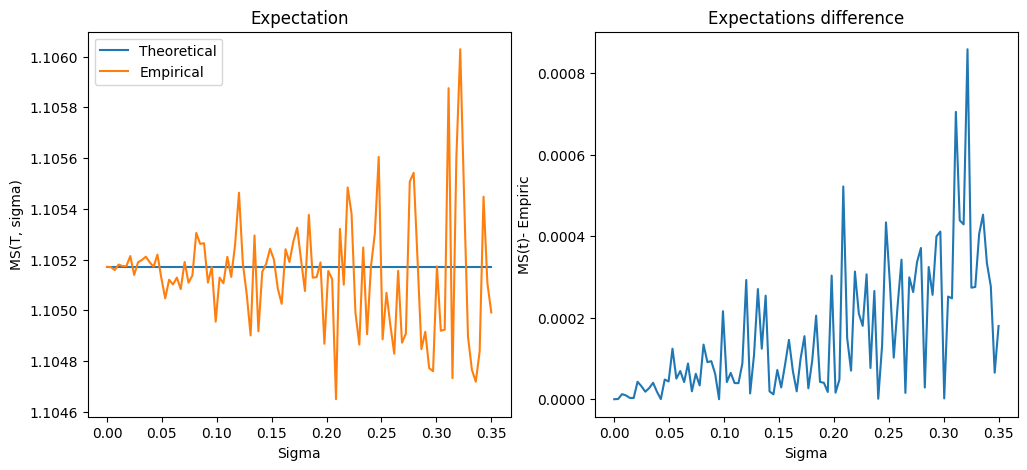

In [15]:
N = 10**6
STEPS = 10
sigmas = np.linspace(0, 0.35, num=100)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

emperical = calc_empirical_expectetions_varying_sigma(sigmas=sigmas, r=R, steps=STEPS, trajectory_num=N)

axs[0].plot(sigmas, np.ones_like(sigmas)*np.exp(R*1), label='Theoretical')
axs[0].plot(sigmas, emperical, label='Empirical')
axs[0].set_title('Expectation')
axs[0].set_xlabel('Sigma')
axs[0].set_ylabel('MS(T, sigma)')
axs[0].legend()

axs[1].plot(sigmas, np.abs(np.ones_like(sigmas)*np.exp(R*1) - emperical))
axs[1].set_title('Expectations difference')
axs[1].set_xlabel('Sigma')
axs[1].set_ylabel('MS(t)- Empiric')

plt.show()

---
# Task 2

Нарисовать графики c(t,x) как функции от x при t = 0.05T, 0.8T, 0.99T.

$c(t,S(t)) = S(0)\Phi(\alpha_{+})-Ke^{-rt}\Phi(\alpha_{-})$

$\alpha_{\pm}=\frac{1}{\sigma\sqrt{\tau}}[\ln{\frac{S(t)}{K}} + (r\pm\frac{\sigma^2}{2})\tau]$

In [48]:
def calculate_option_price(S0=1, K=1.3, r=0.0, sigma=0.0, steps=100, trajectory_num=100,
                           start=0, end=1, S=None):
    """
        Calculates an option price respect to the price change of an underlying

        Arguments:
            S0, float - a start price of the underlying
            K, float - a strike
            r, float - a riskless rate
            sigma, float - volatility
            steps, float - a number if time steps
            trajectory_num - a number of trajectories to consider while modulating
            start, float - start time
            end, float - 
    
    """
    if S is None:
        S = modulate_asset_price(S0=S0, r=r, sigma=sigma, steps=steps, start=start, end=end,
                                trajectory_num=trajectory_num).mean(axis=0)
    alpha_pl = (np.log(S / K) + (r + sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - np.linspace(start, end, steps+1) + 1e-12)
    alpha_ms = (np.log(S / K) + (r - sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - np.linspace(start, end, steps+1) + 1e-12)
    return S * norm.cdf(alpha_pl, loc=0, scale=1) - K * np.exp(-r*(end - np.linspace(start, end, steps+1))) * norm.cdf(alpha_ms, loc=0, scale=1), S

In [17]:
R

0.1

[20, 320, 396]


/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_9610/4223596817.py:20: RuntimeWarning: divide by zero encountered in divide
  alpha_pl = (np.log(S / K) + (r + sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - np.linspace(start, end, steps+1))
/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_9610/4223596817.py:21: RuntimeWarning: divide by zero encountered in divide
  alpha_ms = (np.log(S / K) + (r - sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - np.linspace(start, end, steps+1))


[]

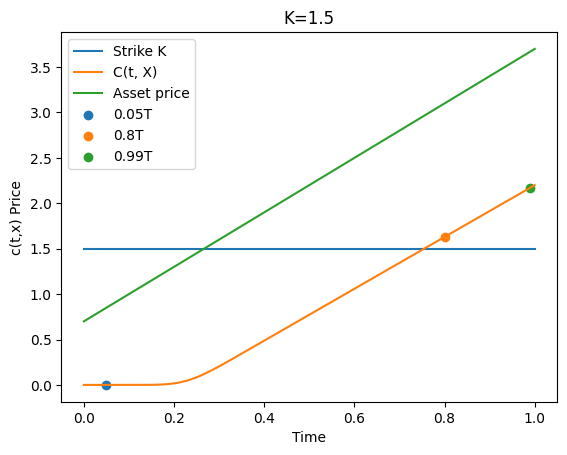

In [18]:
K = 1.5
START = 0
END=1
STEPS = 400

times = [0.05, 0.8, 0.99]
indexes = [int(i*(STEPS+1) * (END - START)) for i in times]
print(indexes)

S = np.linspace(0.7, 3.7, STEPS+1)
# S = None

option_prices, ss = calculate_option_price(K=K, r=R, sigma=0.1, trajectory_num=10**4, 
                                           start=START, end=END, steps=STEPS, S=S)

plt.plot( np.linspace(START, END, STEPS+1), np.ones_like(ss)*K, label='Strike K')
plt.plot( np.linspace(START, END, STEPS+1), option_prices, label='C(t, X)')
plt.plot( np.linspace(START, END, STEPS+1), ss, label='Asset price')

plt.scatter( np.linspace(START, END, STEPS+1)[indexes[0]], option_prices[indexes[0]], label='0.05T')
plt.scatter( np.linspace(START, END, STEPS+1)[indexes[1]], option_prices[indexes[1]], label='0.8T')
plt.scatter( np.linspace(START, END, STEPS+1)[indexes[2]], option_prices[indexes[2]], label='0.99T')

plt.title(f"K={K}")
plt.xlabel('Time')
plt.ylabel('c(t,x) Price')
plt.legend()
plt.plot()

In [19]:
def calculate_option_price_fixed(S, current_t, K=1.3, r=0.0, sigma=0.0, end=1):
    """
        Calculates an option price respect to the price change of an underlying

        Arguments:
            S0, float - a start price of the underlying
            K, float - a strike
            r, float - a riskless rate
            sigma, float - volatility
            steps, float - a number if time steps
            trajectory_num - a number of trajectories to consider while modulating
            start, float - start time
            end, float - 
    
    """
    alpha_pl = (np.log(S / K) + (r + sigma**2 / 2) * (end - current_t)) / sigma / np.sqrt(end - current_t)
    alpha_ms = (np.log(S / K) + (r - sigma**2 / 2) * (end - current_t)) / sigma / np.sqrt(end - current_t)
    return S * norm.cdf(alpha_pl, loc=0, scale=1) - K * np.exp(-r*(end - current_t)) * norm.cdf(alpha_ms, loc=0, scale=1), S

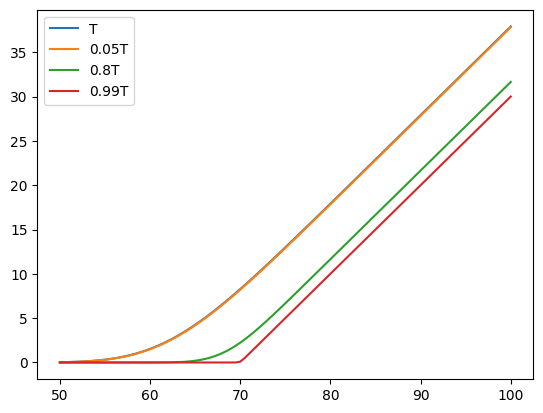

In [39]:
T = 1
ti = [0.01*T, 0.8*T, 0.999*T]
K = 70
STEPS = 100
S = np.linspace(50,100, STEPS+1)

option_prices, ss = calculate_option_price_fixed(S=S, current_t=0, K=K, r=R, sigma=0.1, end=END)
plt.plot(S, option_prices,label='T')

option_prices, ss = calculate_option_price_fixed(S=S, current_t=ti[0], K=K, r=R, sigma=0.1, end=END)
plt.plot(S, option_prices, label='0.05T')

option_prices, ss = calculate_option_price_fixed(S=S, current_t=ti[1],K=K, r=R, sigma=0.1, end=END)
plt.plot(S, option_prices, label='0.8T')

option_prices, ss = calculate_option_price_fixed(S=S, current_t=ti[2], K=K, r=R, sigma=0.1, end=END)
plt.plot(S, option_prices, label='0.99T')

plt.legend()
plt.show()


---
# Task 3

Нарисовать графики греческих параметров $\delta,\  \gamma,\ \theta,\ k,\ vega,\ \rho $как фукнции от х

$\delta = c'_x(t,x) = \Phi(\alpha_{+}(\tau, x))$ <br>

$\gamma = c''_{xx}(t,x) = \Phi'(\alpha_{+})\frac{1}{x\sigma\sqrt{\tau}} = \frac{1}{\sqrt{2\pi}}e^{-\frac{\alpha_{+}^2}{2}}\frac{1}{x\sigma\sqrt{\tau}}$ <br>

$\theta = c'_t(t,x) = -Kre^{-r\tau}\Phi(\alpha_{-}) - \frac{\sigma x}{2\sqrt{\tau}}\frac{1}{\sqrt{2\pi}}e^{-\frac{\alpha_{+}^2}{2}}$ <br>

$vega=c'_{\sigma}(t,x)=\frac{x\sqrt{\tau}}{\sqrt{2\pi}}e^{-\frac{\alpha_{+}^2}{2}}$ <br>

$k = c'_K(t,x) = -e^{-r\tau}\Phi(\alpha_{-})$ <br>

$rho = c'_r(t,x) = K\tau e^{-r\tau}\phi(\alpha_{-})$

In [25]:
norm.cdf(1.1, loc=0, scale=1)

0.8643339390536173

In [26]:
norm.cdf(np.linspace(0, 1, 10), loc=0, scale=1)

array([0.5       , 0.54423588, 0.58792955, 0.63055866, 0.67163936,
       0.71074264, 0.74750746, 0.78164998, 0.8129686 , 0.84134475])

In [27]:
R = 0.01 / 365
Sigma = 0.1

In [28]:
def delta(S0=1., K=1., sigma=0., r=0., start=0, end=1, steps=100, trajectory_num=100, S=None) -> np.ndarray:
    """
        math: `$\delta = c'_x(t,x) = \Phi(\alpha_{+}(\tau, x))$`
    """
    if S is None:
        S = modulate_asset_price(S0=S0, r=r, sigma=sigma, steps=steps, start=start, end=end,
                                trajectory_num=trajectory_num).mean(axis=0)
    alpha_ms = (np.log(S / K) + (r - sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - start)
    deltas = norm.cdf(alpha_ms)
    return deltas


def gamma(S0=1., K=1., sigma=0., r=0., start=0, end=1, steps=100, trajectory_num=100, S=None) -> np.ndarray:
    """
        math: `$\gamma = c''_{xx}(t,x) = \Phi'(\alpha_{+})\frac{1}{x\sigma\sqrt{\tau}}`
        math: `= \frac{1}{\sqrt{2\pi}}e^{-\frac{\alpha_{+}^2}{2}}\frac{1}{x\sigma\sqrt{\tau}}$`
    """
    if S is None:
        S = modulate_asset_price(S0=S0, r=r, sigma=sigma, steps=steps, start=start, end=end,
                                trajectory_num=trajectory_num).mean(axis=0)
    alpha_pl = (np.log(S / K) + (r + sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - start)
    gammas = np.exp(-alpha_pl**2 / 2) / S / sigma / np.sqrt(2 * np.pi * (end - np.linspace(start, end, steps+1)))
    return gammas


def theta(S0=1., K=1., sigma=0., r=0., start=0, end=1, steps=100, trajectory_num=100, S=None) -> np.ndarray:
    """
        math: `$\theta = c'_t(t,x) =`
        math: `-Kre^{-r\tau}\Phi(\alpha_{-}) - \frac{\sigma x}{2\sqrt{\tau}}\frac{1}{\sqrt{2\pi}}e^{-\frac{\alpha_{+}^2}{2}}$`
    """
    if S is None:
        S = modulate_asset_price(S0=S0, r=r, sigma=sigma, steps=steps, start=start, end=end,
                                trajectory_num=trajectory_num).mean(axis=0)
    alpha_pl = (np.log(S / K) + (r + sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - start)
    alpha_ms = (np.log(S / K) + (r - sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - start)
    thetas = -K * r * np.exp(-r*(end - np.linspace(start, end, steps+1)))*norm.cdf(alpha_ms, loc=0, scale=1)
    thetas -= sigma * S * np.exp(-alpha_pl**2/2) / 2 / np.sqrt(2*np.pi * (end - np.linspace(start, end, steps+1)))
    return thetas
    

def k_derivative(S0=1., K=1., sigma=0., r=0., start=0, end=1, steps=100, trajectory_num=100, S=None) -> np.ndarray:
    """
        math: `$k = c'_K(t,x) = -e^{-r\tau}\Phi(\alpha_{-})$`
    """
    if S is None:
        S = modulate_asset_price(S0=S0, r=r, sigma=sigma, steps=steps, start=start, end=end,
                                trajectory_num=trajectory_num).mean(axis=0)
    alpha_ms = (np.log(S / K) + (r - sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - start)
    k = -np.exp(-r*(end - np.linspace(start, end, steps+1))) * norm.cdf(alpha_ms, loc=0, scale=1)
    return k
    


def vega(S0=1., K=1., sigma=0., r=0., start=0, end=1, steps=100, trajectory_num=100, S=None) -> np.ndarray:
    """
        math: `$vega=c'_{\sigma}(t,x)=\frac{x\sqrt{\tau}}{\sqrt{2\pi}}e^{-\frac{\alpha_{+}^2}{2}}$`
    """
    if S is None:
        S = modulate_asset_price(S0=S0, r=r, sigma=sigma, steps=steps, start=start, end=end,
                                trajectory_num=trajectory_num).mean(axis=0)
    alpha_pl = (np.log(S / K) + (r + sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - start)
    vegas = S * np.sqrt(end - np.linspace(start, end, steps+1)) * np.exp(-alpha_pl**2/2)/np.sqrt(2*np.pi)
    return vegas
    


def rho(S0=1., K=1., sigma=0., r=0., start=0, end=1, steps=100, trajectory_num=100, S=None) -> np.ndarray:
    """
        math: `$rho = c'_r(t,x) = K\tau e^{-r\tau}\phi(\alpha_{-})$`
    """
    if S is None:
        S = modulate_asset_price(S0=S0, r=r, sigma=sigma, steps=steps, start=start, end=end,
                                trajectory_num=trajectory_num).mean(axis=0)
    alpha_ms = (np.log(S / K) + (r - sigma**2 / 2) * (end - np.linspace(start, end, steps+1))) / sigma / np.sqrt(end - start)
    rhos = K * (end - (np.linspace(start, end, steps+1))) * np.exp(-r*(end - np.linspace(start, end, steps+1))) * norm.cdf(alpha_ms, loc=0, scale=1)
    return rhos

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_9610/1401836303.py:22: RuntimeWarning: divide by zero encountered in divide
  gammas = np.exp(-alpha_pl**2 / 2) / S / sigma / np.sqrt(2 * np.pi * (end - np.linspace(start, end, steps+1)))
/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_9610/1401836303.py:37: RuntimeWarning: divide by zero encountered in divide
  thetas -= sigma * S * np.exp(-alpha_pl**2/2) / 2 / np.sqrt(2*np.pi * (end - np.linspace(start, end, steps+1)))


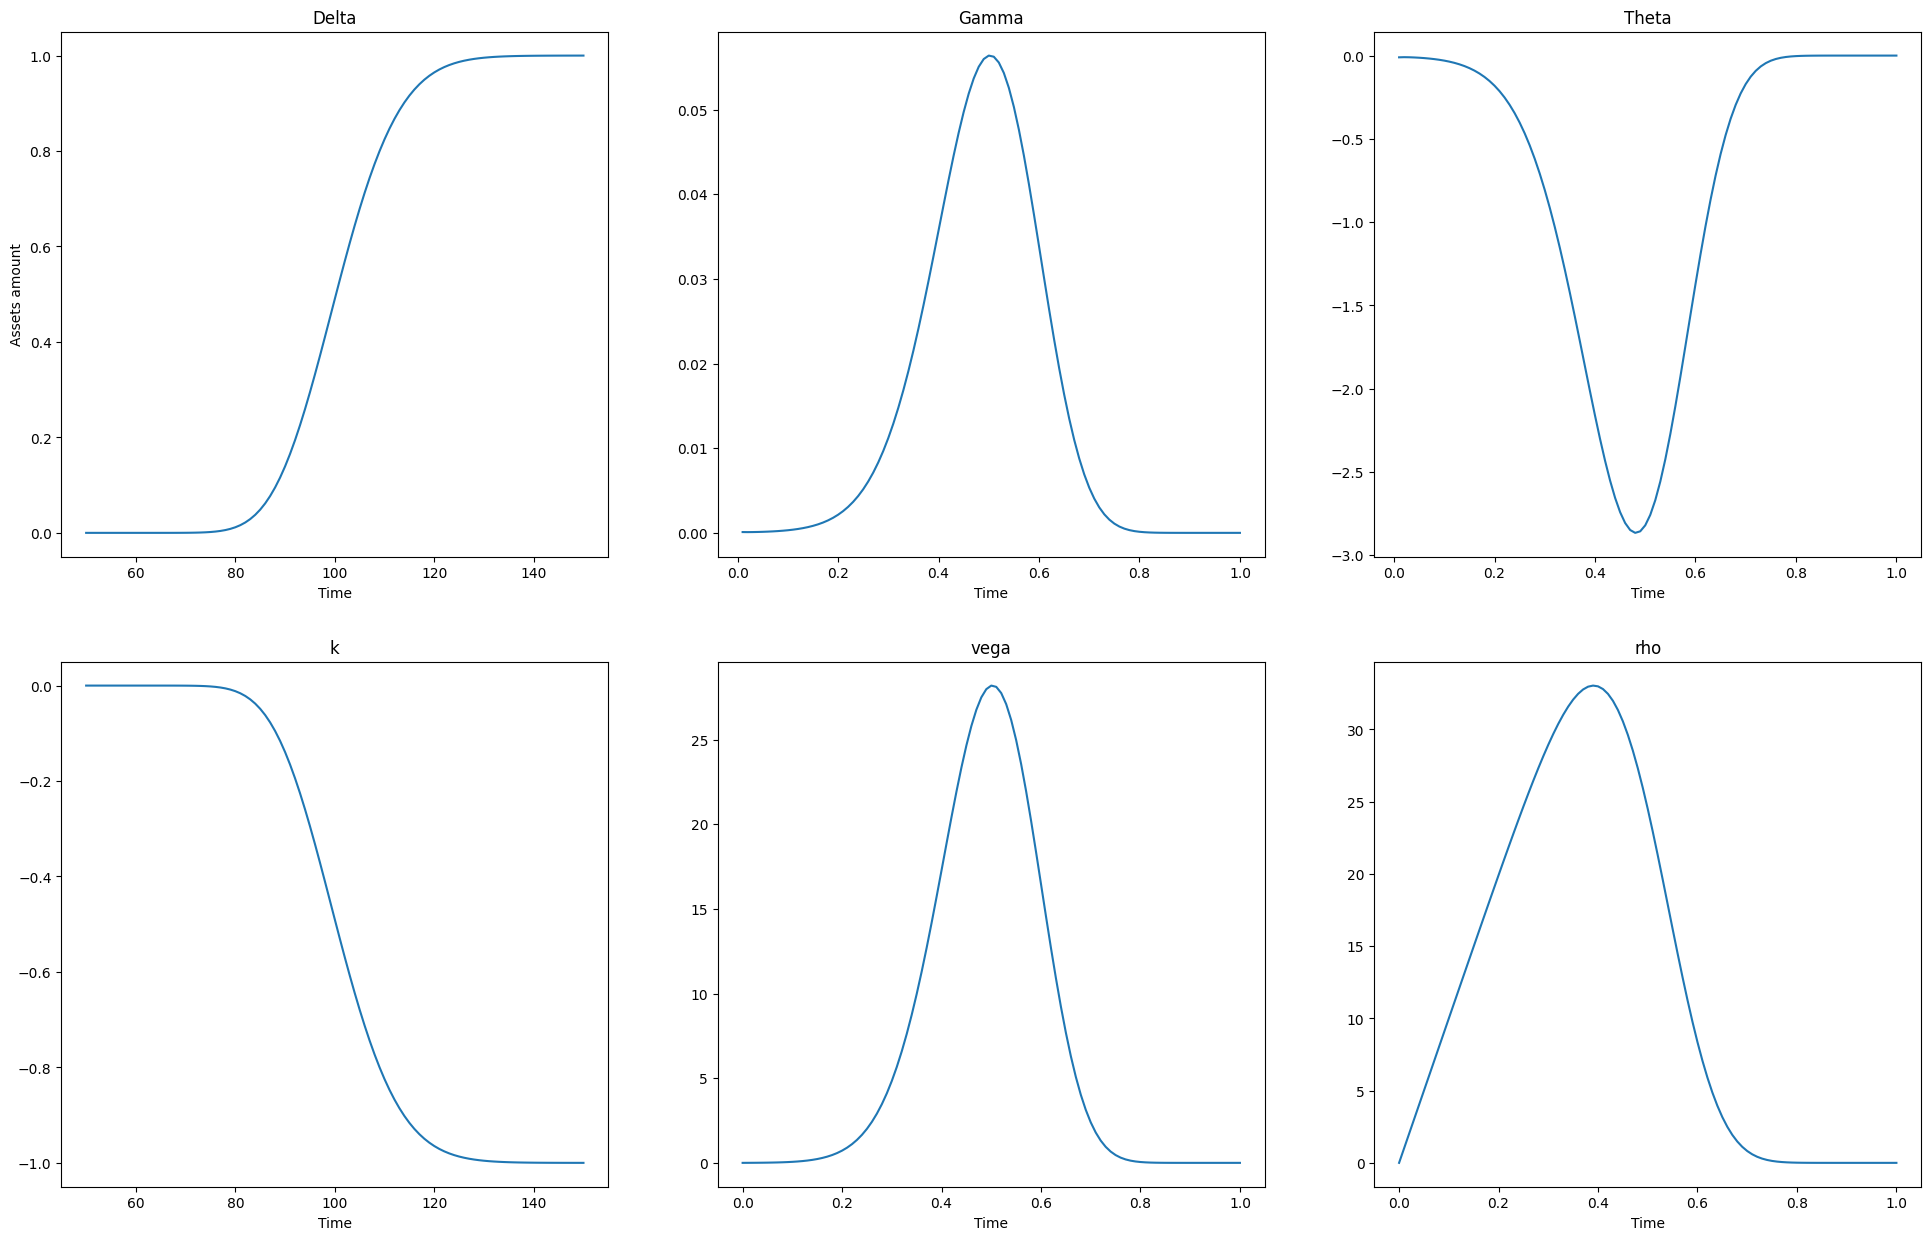

In [29]:
R = 0.5 #/ 365
Sigma = 0.1
S0 = 50
K = 100
END = 1
STEPS = 100


S = np.linspace(50, 150, STEPS+1)
# S = modulate_asset_price(S0, r=R, sigma=Sigma, steps=STEPS, trajectory_num=N).mean(axis=0)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(2*12, 3*5))


# delta
axs[0, 0].plot(S, delta(S0=S0, K=K, sigma=Sigma, steps=STEPS,
                                                             end=END, S=S,
                                                             trajectory_num=N))
axs[0, 0].set_title('Delta')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Assets amount')


# gamma
axs[0, 1].plot(np.linspace(END, START, STEPS+1), gamma(S0=S0, K=K, sigma=Sigma, steps=STEPS,
                                                             end=END, S=S,
                                                             trajectory_num=N))
axs[0, 1].set_title('Gamma')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('')


# theta
axs[0, 2].plot(np.linspace(END, START, STEPS+1), theta(S0=S0, K=K, sigma=Sigma, steps=STEPS,
                                                             end=END, S=S,
                                                             trajectory_num=N))
axs[0, 2].set_title('Theta')
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('')


# k
axs[1, 0].plot(S, k_derivative(S0=S0, K=K, sigma=Sigma, 
                                                              steps=STEPS, end=END,  S=S,
                                                              trajectory_num=N))
axs[1, 0].set_title('k')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('')


# vega
axs[1, 1].plot(np.linspace(END, START, STEPS+1), vega(S0=S0, K=K, sigma=Sigma, steps=STEPS,  S=S,
                                                      end=END, trajectory_num=N))
axs[1, 1].set_title('vega')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('')


# rho
axs[1, 2].plot(np.linspace(END, START, STEPS+1), rho(S0=S0, K=K, sigma=Sigma, steps=STEPS,  S=S,
                                                     end=END, trajectory_num=N))
axs[1, 2].set_title('rho')
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('')


# plt.tight_layout()
plt.show()

---
# Task 4

Рассмотрите портфель $X(t) = c(t, S(t)) - c_x(t, S(t))S(t)$, <br>
где $c_x(t,S(t))$ - частная производная по х. Разделить отрезок [0, T] точками $t_i = \frac{iT}{n}$, смоделируйте процесс S(t) и постройте график портфеля X(t) как функции от t в точках t_i. Постройте в том же окне график $e^{rt} X(0)$ как функции от t

$c(t, x) - x c_x(t,x) = xN(d_{+}(t,x)) - Ke^{-r(T-t)}N(d_{-}) - xN(d_{+})=- Ke^{-r(T-t)}N(d_{-})$

In [75]:
indeces = [0, 1, 4, 14]

In [80]:
def plot_portfolio(N, R, S0, S, K, Sigma, steps, start, end) -> None:
    """
    """
    _time = np.linspace(start, end, steps+1)

    # analytic
    x = - K * np.exp(-R * (end - _time)) * norm.cdf((np.log(S / K) + (R - Sigma**2 / 2) * (END - _time)) / Sigma / np.sqrt(END - _time + 1e-12))

    # call price
    call, ss = calculate_option_price(S0=S0, K=K, r=R, sigma=Sigma, steps=STEPS, trajectory_num=N, 
                                    start=START, end=END, S=S)

    deltas = delta(S0=S0, K=K, sigma=Sigma, r=R, start=START, end=END, S=S, steps=STEPS)
    # print(deltas)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    X0 = (call - deltas * S)[0]

    axs[0, 0].plot(call - deltas * S, label='c - xd')
    axs[0, 0].plot(X0*np.exp(_time * R), label='x_0 from c - xd')
    axs[0, 0].plot(x[0]*np.exp(_time * R), label='x_0 exp')
    axs[0, 0].plot(x, label='-k exp')
    axs[0, 0].set_title('X(t)')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('X(t)')
    axs[0, 0].legend()

    axs[0, 1].plot(S, label='S(t)')
    axs[0, 1].plot(np.ones_like(S) * K, label='K')
    axs[0, 1].set_title('S(t)')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('S(t)')
    axs[0, 1].legend()

    axs[1, 0].plot(call, label='C(t,x)')
    axs[1, 0].set_title('Delta and C')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].legend()

    axs[1, 1].plot(deltas * S, label='Delta(t, x) * S(t)')
    axs[1, 1].plot(deltas * S, label='Delta(t, x) * S(t)')
    axs[1, 1].set_title('Delta and C')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].legend()


    plt.tight_layout()
    plt.show()


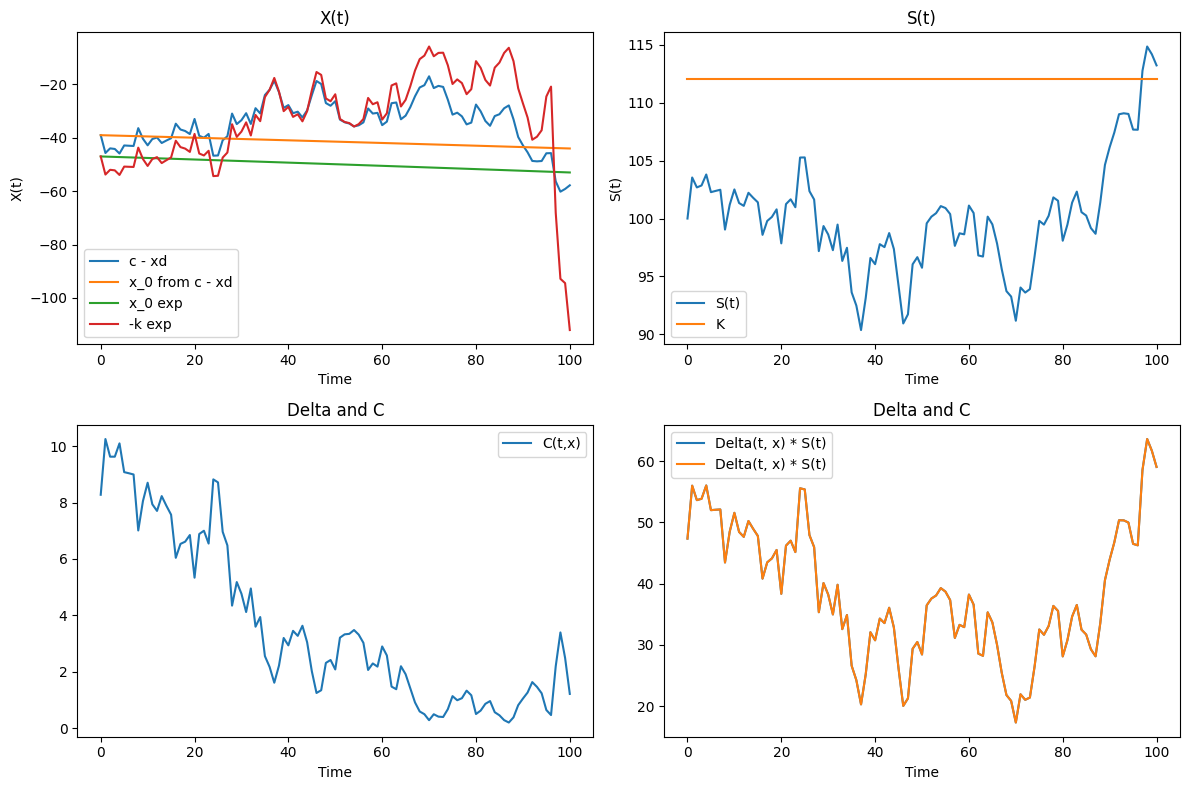

In [82]:
N = 10**4
R = 0.12
S0= 100
K = S0 * 1.12
Sigma = 0.2
STEPS=100
START = 0
END = 1

S = modulate_asset_price(S0=S0, r=R, sigma=Sigma, steps=STEPS, 
                            trajectory_num=N, start=START, end=END, seed=7)

plot_portfolio(N, R, S0, S[0], K, Sigma, STEPS, START, END)

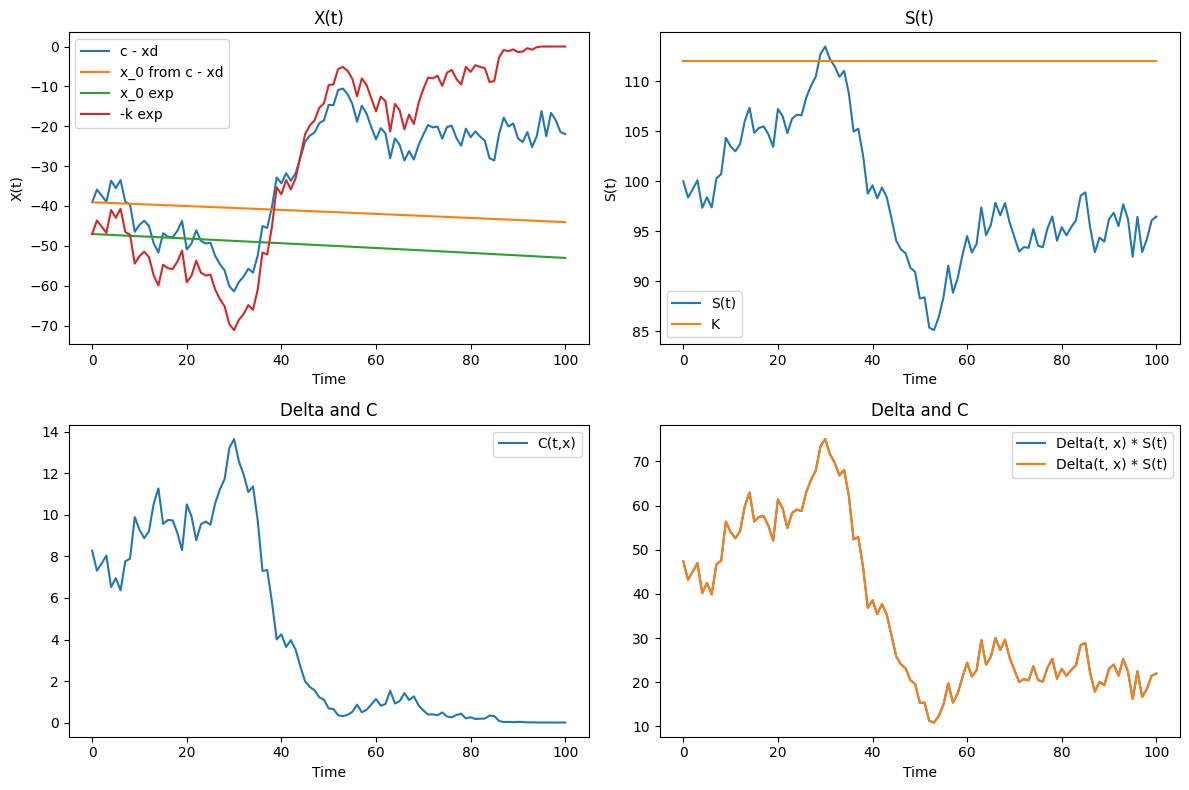

In [83]:
plot_portfolio(N, R, S0, S[1], K, Sigma, STEPS, START, END)

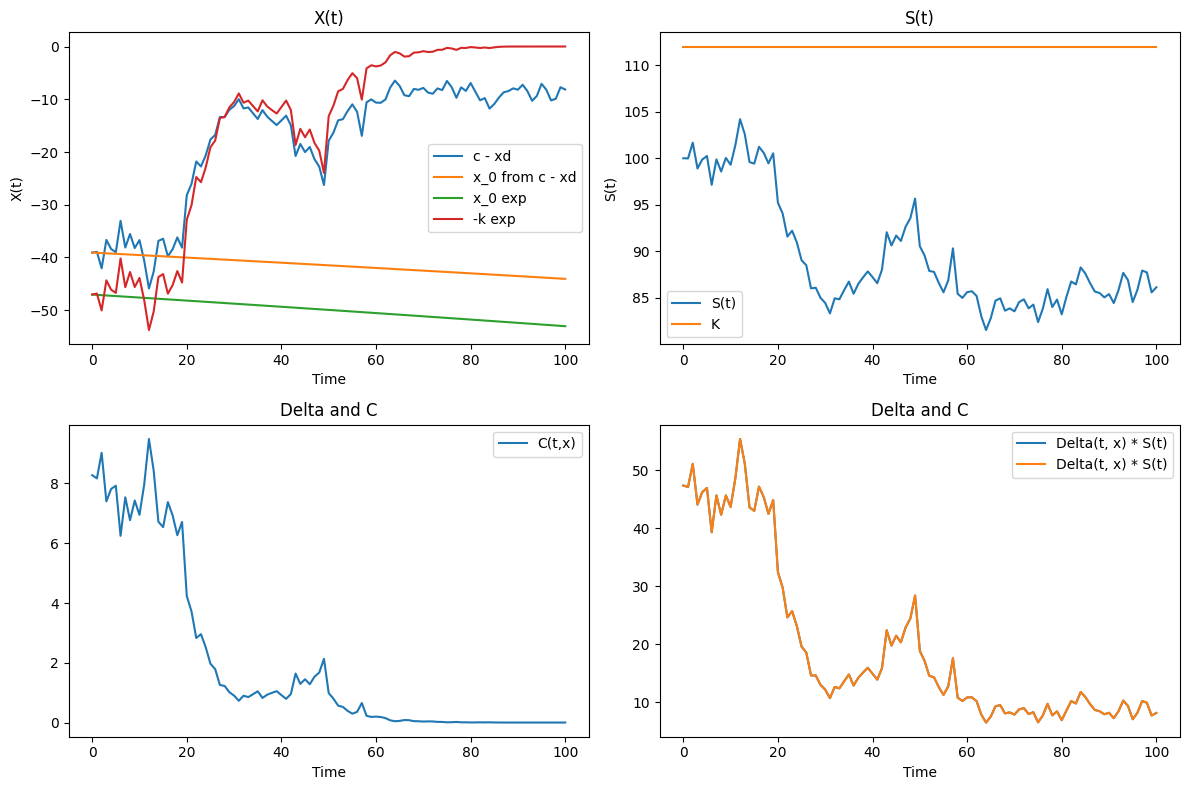

In [84]:
plot_portfolio(N, R, S0, S[4], K, Sigma, STEPS, START, END)

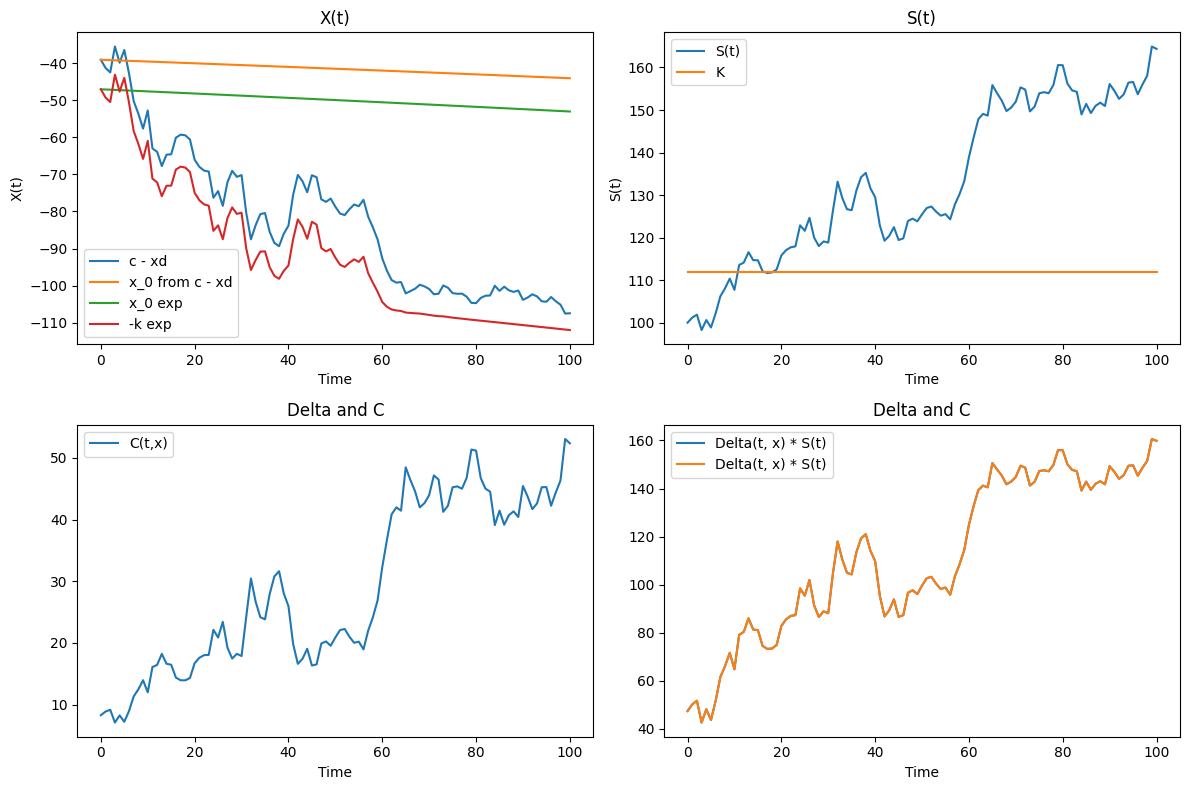

In [85]:
plot_portfolio(N, R, S0, S[14], K, Sigma, STEPS, START, END)